### Importing Libraries

In [1]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix

### Importing dataset

In [2]:
benign=pd.read_csv("BabyMonitor/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=20), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('BabyMonitor/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('BabyMonitor/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [3]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=20))

### Plotting samples of benign and malicious data

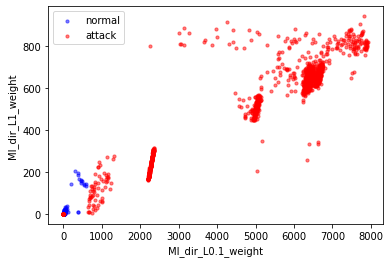

In [4]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [5]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L0.1_weight', 'score': 1.2260028446133084},
 {'feature': 'H_L0.1_weight', 'score': 1.2260027979952752},
 {'feature': 'MI_dir_L1_weight', 'score': 1.2051623975391526},
 {'feature': 'H_L1_weight', 'score': 1.2051620764007813},
 {'feature': 'MI_dir_L3_weight', 'score': 1.202508947596725}]

### Predicting Anomaly

In [6]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [7]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [8]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
1826/1826 [==============================] - 9s 4ms/step - loss: 0.4969 - val_loss: 0.1948
Epoch 2/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.1651 - val_loss: 0.1582
Epoch 3/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.1276 - val_loss: 0.1169
Epoch 4/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.0982 - val_loss: 0.1005
Epoch 5/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.0825 - val_loss: 0.0885
Epoch 6/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.0704 - val_loss: 0.0671
Epoch 7/100
1826/1826 [==============================] - 6s 4ms/step - loss: 0.0610 - val_loss: 0.0778
Epoch 8/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.0562 - val_loss: 0.0655
Epoch 9/100
1826/1826 [==============================] - 8s 4ms/step - loss: 0.0609 - val_loss: 0.0553
Epoch 10/100
1826/1826 [==============================] - 7s 4ms/step - l

### Predict train dataset

In [9]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.9886155479088559
Precision 0.9777699660188487
Recall 0.9999657610463424
Confusion Matrix [[57085  1328]
 [    2 58411]]
For n 2
Accuracy
0.8855819766147947
Precision 0.9837621890974698
Recall 0.7841062777121531
Confusion Matrix [[57657   756]
 [12611 45802]]
For n 3
Accuracy
0.887893105986681
Precision 0.989500518492914
Recall 0.7841062777121531
Confusion Matrix [[57927   486]
 [12611 45802]]
For n 4
Accuracy
0.8892712238713985
Precision 0.9929756097560976
Recall 0.7840891582353243
Confusion Matrix [[58089   324]
 [12612 45801]]
For n 5
Accuracy
0.8901443171896667
Precision 0.9951978444623106
Recall 0.7840720387584955
Confusion Matrix [[58192   221]
 [12613 45800]]
For n 6
Accuracy
0.8905637443719719
Precision 0.9962585921865483
Recall 0.7840720387584955
Confusion Matrix [[58241   172]
 [12613 45800]]
For n 7
Accuracy
0.8909403728622053
Precision 0.9972130290890089
Recall 0.7840720387584955
Confusion Matrix [[58285   128]
 [12613 45800]]

### Test data

In [10]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 1
Treshold  9.942927792274865
Accuracy  0.8926028006984627
Precision  0.9999128065395095
Recall 0.7852740781319547
Confusion Matrix [[58410     4]
 [12543 45871]]


### Variational Autoencoder

In [11]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [12]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8962 - val_loss: 0.8865
Epoch 2/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.8140 - val_loss: 0.8826
Epoch 3/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.7743 - val_loss: 0.8802
Epoch 4/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8716 - val_loss: 0.8787
Epoch 5/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8040 - val_loss: 0.8793
Epoch 6/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8081 - val_loss: 0.8781
Epoch 7/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8103 - val_loss: 0.8766
Epoch 8/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8573 - val_loss: 0.8763
Epoch 9/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8087 - val_loss: 0.8754
Epoch 10/100
1826/1826 [==============================] - 7s 4ms/step - l

### Train

In [13]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9881875609881362
Precision 0.9770320681175664
Recall 0.9998801636621985
Confusion Matrix [[57040  1373]
 [    7 58406]]
For n 2
Accuracy
0.9911492304795165
Precision 0.9828012722346566
Recall 0.9997945662780545
Confusion Matrix [[57391  1022]
 [   12 58401]]
For n 3
Accuracy
0.9927927002550802
Precision 0.9859870675828536
Recall 0.9997945662780545
Confusion Matrix [[57583   830]
 [   12 58401]]
For n 4
Accuracy
0.9942906544775991
Precision 0.9889253903207234
Recall 0.9997774468012257
Confusion Matrix [[57759   654]
 [   13 58400]]
For n 5
Accuracy
0.9957458100080462
Precision 0.9917804496977107
Recall 0.9997774468012257
Confusion Matrix [[57929   484]
 [   13 58400]]
For n 6
Accuracy
0.9965932241110712
Precision 0.9934507102151909
Recall 0.9997774468012257
Confusion Matrix [[58028   385]
 [   13 58400]]
For n 7
Accuracy
0.9968928149555749
Precision 0.9940425531914894
Recall 0.9997774468012257
Confusion Matrix [[58063   350]
 [   13 58400

### Test

In [14]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 10
Treshold  61.796758290182765
Accuracy  0.9977488273359126
Precision  0.9958051259314837
Recall 0.9997089738761256
Confusion Matrix [[58168   246]
 [   17 58397]]


### Undercomplete Autoencoder

In [15]:
def uc_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(15, activation='relu')(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [16]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = uc_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_undercomplete.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.9357 - val_loss: 0.8673
Epoch 2/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8242 - val_loss: 0.8580
Epoch 3/100
1826/1826 [==============================] - 5s 2ms/step - loss: 0.8108 - val_loss: 0.8550
Epoch 4/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.7864 - val_loss: 0.8533
Epoch 5/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8160 - val_loss: 0.8525
Epoch 6/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.7690 - val_loss: 0.8519
Epoch 7/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8033 - val_loss: 0.8515
Epoch 8/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8282 - val_loss: 0.8512
Epoch 9/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.7776 - val_loss: 0.8510
Epoch 10/100
1826/1826 [==============================] - 3s 2ms/step - l

In [17]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9883330765411809
Precision 0.977309996318731
Recall 0.9998801636621985
Confusion Matrix [[57057  1356]
 [    7 58406]]
For n 2
Accuracy
0.9913033057709756
Precision 0.9830990657352074
Recall 0.9997945662780545
Confusion Matrix [[57409  1004]
 [   12 58401]]
For n 3
Accuracy
0.992809819731909
Precision 0.9860203616471661
Recall 0.9997945662780545
Confusion Matrix [[57585   828]
 [   12 58401]]
For n 4
Accuracy
0.9943505726465
Precision 0.9890426270597998
Recall 0.9997774468012257
Confusion Matrix [[57766   647]
 [   13 58400]]
For n 5
Accuracy
0.9957372502696318
Precision 0.9917636070306529
Recall 0.9997774468012257
Confusion Matrix [[57928   485]
 [   13 58400]]
For n 6
Accuracy
0.9966103435878999
Precision 0.9934845108279604
Recall 0.9997774468012257
Confusion Matrix [[58030   383]
 [   13 58400]]
For n 7
Accuracy
0.9968842552171605
Precision 0.9940256336062365
Recall 0.9997774468012257
Confusion Matrix [[58062   351]
 [   13 58400]]
Fo

In [18]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
uc_acc = accuracy_score(Y_test, Y_pred)
uc_precision = precision_score(Y_test, Y_pred)
uc_recall = recall_score(Y_test, Y_pred)
uc_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',uc_acc)
print('Precision ',uc_precision)
print("Recall",uc_recall)
print('Confusion Matrix',uc_cm)

Test-----------------
best n 10
Treshold  61.10248873964882
Accuracy  0.99776594651967
Precision  0.9958390886922119
Recall 0.9997089738761256
Confusion Matrix [[58170   244]
 [   17 58397]]


### Sparse Autoencoder

In [36]:
def sparse_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(200, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [37]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1826/1826 [==============================] - 7s 3ms/step - loss: 0.8942 - val_loss: 0.8526
Epoch 2/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.7940 - val_loss: 0.8505
Epoch 3/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8145 - val_loss: 0.8499
Epoch 4/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8131 - val_loss: 0.8485
Epoch 5/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8054 - val_loss: 0.8483
Epoch 6/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.7885 - val_loss: 0.8481
Epoch 7/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.7684 - val_loss: 0.8481
Epoch 8/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8085 - val_loss: 0.8478
Epoch 9/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.8571 - val_loss: 0.8478
Epoch 10/100
1826/1826 [==============================] - 6s 3ms/step - l

In [38]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.9883416362795953
Precision 0.9773263499606767
Recall 0.9998801636621985
Confusion Matrix [[57058  1355]
 [    7 58406]]
For n 2
Accuracy
0.9913033057709756
Precision 0.9830990657352074
Recall 0.9997945662780545
Confusion Matrix [[57409  1004]
 [   12 58401]]
For n 3
Accuracy
0.992809819731909
Precision 0.9860203616471661
Recall 0.9997945662780545
Confusion Matrix [[57585   828]
 [   12 58401]]
For n 4
Accuracy
0.9943676921233288
Precision 0.9890761283766619
Recall 0.9997774468012257
Confusion Matrix [[57768   645]
 [   13 58400]]
For n 5
Accuracy
0.995720130792803
Precision 0.9917299234126378
Recall 0.9997774468012257
Confusion Matrix [[57926   487]
 [   13 58400]]
For n 6
Accuracy
0.9966103435878999
Precision 0.9934845108279604
Recall 0.9997774468012257
Confusion Matrix [[58030   383]
 [   13 58400]]
For n 7
Accuracy
0.9968842552171605
Precision 0.9940256336062365
Recall 0.9997774468012257
Confusion Matrix [[58062   351]
 [   13 58400]]

In [39]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 10
Treshold  61.01710258299022
Accuracy  0.9977488273359126
Precision  0.9958051259314837
Recall 0.9997089738761256
Confusion Matrix [[58168   246]
 [   17 58397]]


### Denoising Autoencoder

In [23]:
def denoise_model(input_dim):
    input_size = input_dim
    hidden_size = 44
    code_size = 5

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)

    autoencoder = Model(input_img, output_img)
    return autoencoder

In [24]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()

noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_opt_noisy = np.clip(x_opt_noisy, 0., 1.)

X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
#x_train_noisy = scaler.fit_transform(x_train_noisy)
#x_opt_noisy = scaler.transform(x_opt_noisy)

#call function to create the model
model = denoise_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(x_train_noisy, X_train,
                    epochs=epochs, validation_data=(x_opt_noisy, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1826/1826 [==============================] - 7s 3ms/step - loss: 0.9977 - val_loss: 0.9274
Epoch 2/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.8990 - val_loss: 0.9218
Epoch 3/100
1826/1826 [==============================] - 7s 4ms/step - loss: 0.8594 - val_loss: 0.9193
Epoch 4/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8445 - val_loss: 0.9322
Epoch 5/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8617 - val_loss: 0.9145
Epoch 6/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8484 - val_loss: 0.9122
Epoch 7/100
1826/1826 [==============================] - 4s 2ms/step - loss: 0.8731 - val_loss: 0.9106
Epoch 8/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8590 - val_loss: 0.9098
Epoch 9/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.8800 - val_loss: 0.9097
Epoch 10/100
1826/1826 [==============================] - 5s 3ms/step - l

In [25]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(x_opt_noisy)
mse = np.mean(np.power(x_opt_noisy - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
X_opt_scaled = scaler.transform(x_opt_noisy)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.5042541899919538
Precision 0.5021361827231386
Recall 1.0
Confusion Matrix [[  497 57916]
 [    0 58413]]
For n 2
Accuracy
0.5077380035266122
Precision 0.5038991735822363
Recall 1.0
Confusion Matrix [[  904 57509]
 [    0 58413]]
For n 3
Accuracy
0.5122233064557548
Precision 0.5061872822752561
Recall 1.0
Confusion Matrix [[ 1428 56985]
 [    0 58413]]
For n 4
Accuracy
0.5190282984951979
Precision 0.5096986989869375
Recall 1.0
Confusion Matrix [[ 2223 56190]
 [    0 58413]]
For n 5
Accuracy
0.5281444199065276
Precision 0.5144797336574539
Recall 1.0
Confusion Matrix [[ 3288 55125]
 [    0 58413]]
For n 6
Accuracy
0.5399140602263195
Precision 0.5207867121956439
Recall 1.0
Confusion Matrix [[ 4663 53750]
 [    0 58413]]
For n 7
Accuracy
0.5561433242600106
Precision 0.529741445763465
Recall 1.0
Confusion Matrix [[ 6559 51854]
 [    0 58413]]
For n 8
Accuracy
0.5747778747881465
Precision 0.5404107688037746
Recall 1.0
Confusion Matrix [[ 8736 49

In [26]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(x_test_noisy, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=20)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_test_scaled = scaler.transform(x_test_noisy)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
denoise_acc = accuracy_score(Y_test, Y_pred)
denoise_precision = precision_score(Y_test, Y_pred)
denoise_recall = recall_score(Y_test, Y_pred)
denoise_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',denoise_acc)
print('Precision ',denoise_precision)
print("Recall",denoise_recall)
print('Confusion Matrix',denoise_cm)

Test-----------------
best n 29
Treshold  4.0820861375619435
Accuracy  0.787277022631561
Precision  0.7015638888221587
Recall 0.9998972848974561
Confusion Matrix [[33568 24846]
 [    6 58408]]


### Deep Neural Net

In [27]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [28]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [30]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
6231/6231 [==============================] - 15s 2ms/step - loss: 0.0042
Epoch 2/100
6231/6231 [==============================] - 13s 2ms/step - loss: 7.6574e-04
Epoch 3/100
6231/6231 [==============================] - 9s 1ms/step - loss: 0.0011A: 0s -
Epoch 4/100
6231/6231 [==============================] - 14s 2ms/step - loss: 0.0018
Epoch 5/100
6231/6231 [==============================] - 11s 2ms/step - loss: 4.7178e-04
Epoch 6/100
6231/6231 [==============================] - 9s 1ms/step - loss: 4.0288e-04
Epoch 7/100
6231/6231 [==============================] - 9s 1ms/step - loss: 8.5626e-04
Epoch 8/100
6231/6231 [==============================] - 9s 1ms/step - loss: 6.8541e-04
Epoch 9/100
6231/6231 [==============================] - 10s 2ms/step - loss: 2.4937e-04
Epoch 10/100
6231/6231 [==============================] - 10s 2ms/step - loss: 3.4414e-04
Epoch 11/100
6231/6231 [==============================] - 7s 1ms/step - loss: 3.2225e-04
Epoch 12/100
6231/6231 [=====

In [31]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [32]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9995292305058632
Precision  0.999491998983998
Recall 0.9995766299745978
Confusion Matrix [[11550     6]
 [    5 11805]]


### Model comparison

In [40]:
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","Undercomplete Autoencoder","Denoising Autoendoer"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,uc_acc,denoise_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,uc_precision,denoise_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,uc_recall,denoise_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,uc_cm, denoise_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

,Model,Accuracy,Precision,Recall,CM
4,Denoising Autoendoer,0.787277,0.701564,0.999897,"[[33568, 24846], [6, 58408]]"
0,Deep AutoEncoder,0.892603,0.999913,0.785274,"[[58410, 4], [12543, 45871]]"
1,Variational AutoEncoder,0.997749,0.995805,0.999709,"[[58168, 246], [17, 58397]]"
2,Sparse AutoEncoder,0.997749,0.995805,0.999709,"[[58168, 246], [17, 58397]]"
3,Undercomplete Autoencoder,0.997766,0.995839,0.999709,"[[58170, 244], [17, 58397]]"
